In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
answers = pd.read_csv('./data/Answer.csv')
survey_2020 = pd.read_csv('./data/2020-survey.csv')
correct_columns = [1, 2, 3, 5, 6, 7, 8, 9, 13, 17, 18, 19, 30, 32, 33, 34, 93, 97, 99, 100, 117, 118]

In [31]:
unused_questions_removed = survey_2020.columns[survey_2020.columns.str.startswith('q')]
survey_2020 = survey_2020[unused_questions_removed]


## Filter out unrelevant questions

In [32]:
answers = answers[answers['QuestionID'].isin(correct_columns)]

## Create survey DataFrame

We want a data frame where each row will represent one users answers to one survey. We create a empty DataFrame and fill it out with one row for each unique UserID found in the answers table.

In [33]:
surveys = pd.DataFrame(columns=['q1', 'q2', 'q3', 'q5', 'q6', 'q7', 'q8', 'q9', 'q13', 'q17', 'q18', 'q19', 'q30', 'q32', 'q33', 'q34', 'q93', 'q97', 'q99', 'q100', 'q117', 'q118' 'Year'])
user_ids = answers['UserID'].unique()
surveys['UserID'] = user_ids

In order to fill out the survey DataFrame we have to iterate through each row in the answers table and set the values in the corresponding row in surveys.

In [34]:
for answer in answers.iterrows():
    user_id = answer[1][2]
    question_id = 'q' + str(answer[1][3])
    answer_text = answer[1][0]
    year = answer[1][1]
    surveys.at[user_id - 1, question_id] = answer_text
    surveys.at[user_id - 1, 'Year'] = year
        
    

Some questions are very similar but does only exists in some years, we choose to combine these questions.

In [35]:
surveys['q17'] = surveys['q17'].combine_first(surveys['q97'])
surveys['q18'] = surveys['q18'].combine_first(surveys['q99'])
surveys['q19'] = surveys['q19'].combine_first(surveys['q100'])

surveys = surveys.drop(['q97', 'q99', 'q100'], axis = 1)


## Pre-processing


## Age
Some age values are negative, therefore those entries will be changed to positive. Also, there are some unrealistic ages, those will be removed.

In [36]:
age_values = surveys['q1'].value_counts()
age_values

30    250
29    229
32    227
31    223
28    220
     ... 
0       1
5       1
70      1
72      1
3       1
Name: q1, Length: 65, dtype: int64

In [37]:
surveys['q1'] = surveys['q1'].str.replace('-','')
surveys['q1'] = surveys['q1'].astype(int)

In [38]:
surveys['q1'] = surveys[surveys['q1'] > 16]
surveys['q1'] = surveys[surveys['q1'] < 100]
age_values = surveys['q1'].value_counts()
age_values
                        

30.0    250
29.0    230
32.0    227
31.0    223
28.0    220
       ... 
72.0      1
74.0      1
17.0      1
70.0      1
99.0      1
Name: q1, Length: 55, dtype: int64

## Gender
The surveys respondents have answered this question in free text format, there fore we had to change many entries to 'other' and group 'Male' and 'male' etc.

In [39]:
gender_values = surveys['q2'].value_counts()
print(gender_values)

surveys['q2'] = surveys['q2'].str.lower()
gender_values = surveys['q2'].value_counts()
gender_values

Male                        2830
Female                       914
male                         212
female                       110
-1                            24
                            ... 
transgender                    1
human                          1
Guy (-ish) ^_^                 1
femmina                        1
male 9:1 female, roughly       1
Name: q2, Length: 101, dtype: int64


male                        3043
female                      1024
-1                            24
nonbinary                      9
non-binary                     9
                            ... 
43                             1
genderqueer woman              1
androgynous                    1
transitioned, m2f              1
female assigned at birth       1
Name: q2, Length: 87, dtype: int64

In [40]:
surveys['q2'] = np.where(((surveys.q2 != 'male') & (surveys.q2 != 'female')),'other',surveys.q2)
gender_values = surveys['q2'].value_counts()
gender_values

male      3043
female    1024
other      151
Name: q2, dtype: int64

## Country
There were entries for 'Unitade States' and 'United States of America'. We grouped them together.

In [41]:
country_values = surveys['q3'].value_counts()
print(country_values)
surveys['q3'] = np.where((surveys.q3 == 'United States of America'),'United States',surveys.q3)
country_values = surveys['q3'].value_counts()
country_values

United States of America    1853
United States                751
United Kingdom               482
Canada                       199
Germany                      136
                            ... 
Vietnam                        1
Brunei                         1
Bahamas, The                   1
Philippines                    1
Thailand                       1
Name: q3, Length: 81, dtype: int64


United States     2604
United Kingdom     482
Canada             199
Germany            136
Netherlands         98
                  ... 
Taiwan               1
Macedonia            1
Belarus              1
Saudi Arabia         1
Thailand             1
Name: q3, Length: 80, dtype: int64

## Mental health disorder
It seems like different surveys used the answer 'Possibly' and 'Maybe' as the same answer so we grouped them together.


In [42]:
q33_values = surveys['q33'].value_counts()
print(q33_values)
surveys['q33'] = np.where((surveys.q33 == 'Possibly'),'Maybe',surveys.q33)
country_values = surveys['q33'].value_counts()
country_values

Yes           1237
No             969
Maybe          327
Possibly       301
Don't Know     124
Name: q33, dtype: int64


Yes           1237
No             969
Maybe          628
Don't Know     124
Name: q33, dtype: int64

## Pre process 2020 survey
In order to concat the 2020 survey to our surveys DataFrame we have to do some pre processing.

In [44]:
survey_2020 = survey_2020[['q1', 'q2', 'q3', 'q5', 'q6', 'q7', 'q8', 'q9', 'q13', 'q17', 'q18', 'q19', 'q30', 'q32', 'q33', 'q34']]
survey_2020.sample(20)


,q1,q2,q3,q5,q6,q7,q8,q9,q13,q17,q18,q19,q30,q32,q33,q34
92,40,Female,India,0,I don't know,0,100-500,1.0,1.0,Difficult,Yes,No,8,No,No,NaN
0,45,Male,United States of America,1,Yes,0,NaN,NaN,NaN,NaN,NaN,NaN,5,Don't Know,Don't Know,NaN
81,29,Male,Sweden,0,No,0,26-100,1.0,1.0,Somewhat easy,Maybe,No,4,No,No,NaN
69,28,female,Germany,0,Yes,1,26-100,0.0,1.0,Somewhat easy,Maybe,Maybe,8,Possibly,Possibly,NaN
15,22,male,Mongolia,1,Yes,0,NaN,NaN,NaN,NaN,NaN,NaN,2,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,27,Male,United States of America,0,No,0,500-1000,0.0,1.0,Somewhat easy,No,No,5,No,No,NaN
60,33,FEMALE,United States of America,0,Yes,1,500-1000,0.0,1.0,Somewhat easy,Yes,Yes,8,Yes,Yes,Yes
29,33,M,India,0,No,1,500-1000,1.0,1.0,Difficult,No,No,7,No,Possibly,NaN
51,41,Male,India,0,No,0,More than 1000,0.0,0.0,Somewhat easy,No,No,5,No,Possibly,NaN


## Plot mental health issues for males and females

Att göra: Lowercase på alla genders, allt som inte är male eller female ska bli other eller tas bort.

In [47]:
surveys['q2'].sample(20)

3509      male
1839      male
758       male
4006      male
1111      male
         ...  
3393      male
4182    female
2231      male
1670      male
2219      male
Name: q2, Length: 20, dtype: object

<AxesSubplot:>

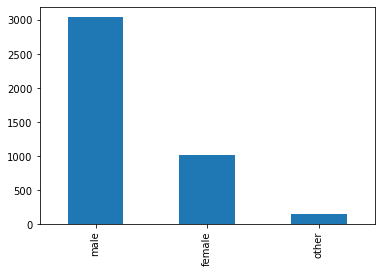

In [50]:
surveys['q2'].value_counts().plot(kind='bar')

male      3043
female    1024
other      151
Name: q2, dtype: int64